# FBRESNET - one example

In [1]:
# Import Packages
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [3]:
# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

### Initialisation
The condition are as follows:
$a=1$ ,
$p=1$ ,
the constraint is $0 <x_i <1$ .

In [4]:
exp1 = FBRestNet(
    model_id = 'model_000_',
    dataset_folder = '../Datasets/',
    model_folder = '../outputs/models/',
    opt_hist_folder = '../outputs/opt_hist/',
    experimentation=Physics(2000,50,1,1),
    nb_blocks=20,
    im_set="Set1",
    noise = 0.05,        
    constraint = 'cube',  
    train_size=50,
    val_size=10,
    batch_size=64,
    lr=3e-1, 
    nb_epochs=50,
    freq_val=1,
    loss_elt=True,
    save_signals=False,
    save_outputs=False,
    save_model=False,
    save_hist=True
    )


### Dataset

In [5]:
train_set, val_set = exp1.CreateDataSet()

In [6]:
data = next(iter(train_set))
y, x = data[0], data[1]            # gets the minibatch
x_true  = np.array(x)
x_bias  = np.array(y)

x_true.shape

(50, 1, 50)

In [7]:
inv      = np.diag(exp1.physics.eigm**(2*exp1.physics.a))

data = next(iter(train_set))
y, x = data[0], data[1]            # gets the minibatch
x_true  = Variable(x,requires_grad=False)
x_bias  = Variable(y,requires_grad=False)
# definition of the initialisation tensor
x_init   = torch.zeros(x_bias.size())
tTTinv   = MyMatmul(inv)
x_init   = tTTinv(y) # no filtration of high frequences
x_init   = Variable(x_init,requires_grad=False)


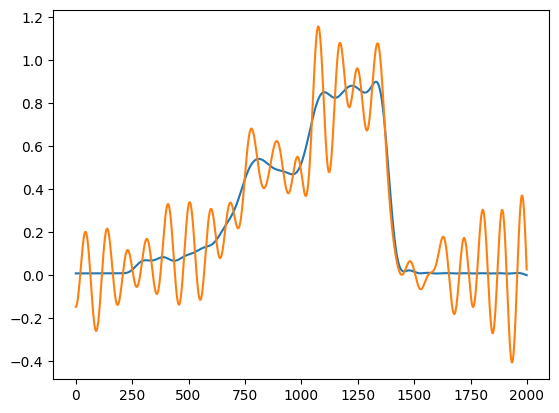

In [8]:
idx=5
plt.plot(exp1.physics.BasisChangeInv(x_true[idx,0]))
plt.plot(exp1.physics.BasisChangeInv(x_init[idx,0]))

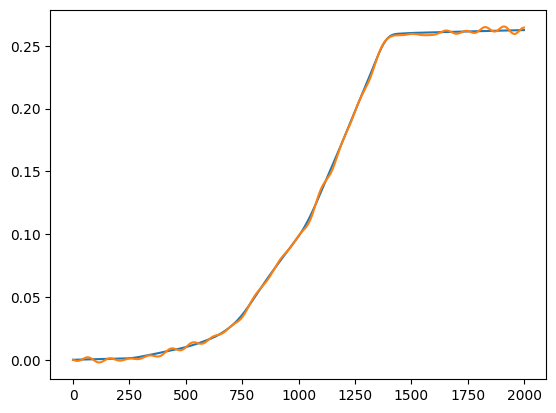

In [9]:
plt.plot(exp1.physics.Compute(exp1.physics.BasisChangeInv(x_true[idx,0])))
plt.plot(exp1.physics.Compute(exp1.physics.BasisChangeInv(x_init[idx,0])))

In [10]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from FBRN.proxop.hypercube import cardan
from FBRN.proxop.hyperslab import cardan_slab

In [11]:
x_true_elt = exp1.model.Layers[0].Pelt(x_true)
x_true_elt.shape

torch.Size([50, 1, 2000])

In [12]:
cardan_slab.apply(0.0001,torch.FloatTensor(x_true_elt),False)

tensor([[[0.0093, 0.0093, 0.0093,  ..., 0.0050, 0.0034, 0.0017]],

        [[0.0095, 0.0095, 0.0095,  ..., 0.0013, 0.0009, 0.0004]],

        [[0.0169, 0.0169, 0.0169,  ..., 0.0014, 0.0009, 0.0005]],

        ...,

        [[0.0083, 0.0083, 0.0083,  ..., 0.0024, 0.0016, 0.0008]],

        [[0.0090, 0.0090, 0.0090,  ..., 0.0021, 0.0014, 0.0007]],

        [[0.0088, 0.0088, 0.0088,  ..., 0.0013, 0.0009, 0.0004]]])

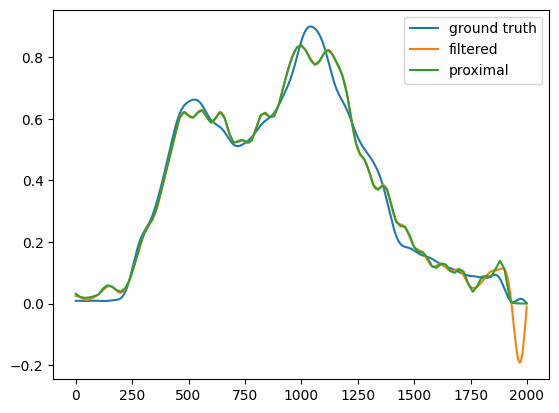

In [16]:
filtered = lowess(exp1.physics.BasisChangeInv(x_init[idx,0]), np.linspace(0,2000-1,2000),
    frac=200/2000,
    it=1,
    delta=20)
plt.plot(exp1.physics.BasisChangeInv(x_true[idx,0]),label='ground truth')
plt.plot(filtered[:, 0], exp1.physics.BasisChangeInv(exp1.physics.BasisChange(filtered[:, 1])),label='filtered')
plt.plot(cardan.apply(0.0001,torch.FloatTensor(filtered[:, 1]),False), label='proximal')
plt.legend()
plt.show()

In [12]:
x_pred    = exp1.model(x_init,x_bias) 

# Compute the loss
loss               = torch.sum(exp1.loss_fn(x_pred,x_true), dim=(1,2))
norm               = torch.norm(x_true.detach(), dim=(1,2))
loss_norm          = torch.mean(torch.div(loss,norm))
print(loss_norm)

tensor(0.0065, grad_fn=<MeanBackward0>)


In [13]:
x_true.shape

torch.Size([50, 1, 50])

In [14]:
basis = exp1.physics.basis
IP_mat = exp1.physics.IP_mat
nx = exp1.physics.nx
cosToelt = (basis).dot(IP_mat)/(2*nx)
cosToelt.shape

(50, 2000)

In [15]:
Pelt = MyMatmul(basis.T)
Peig = MyMatmul((basis).dot(IP_mat)/(2*nx))

In [16]:
print(x_true.shape)
print(Pelt(x_true).shape)
print(Peig(Pelt(x_true)).shape)

torch.Size([50, 1, 50])
torch.Size([50, 1, 2000])
torch.Size([50, 1, 50])


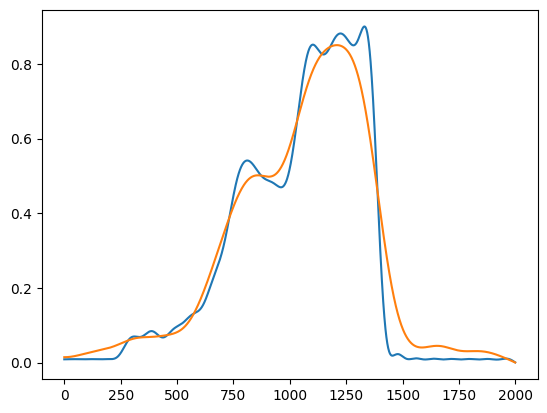

In [17]:
x_pred_eig = x_pred.detach().numpy()[idx,0]
x_pred_elt = exp1.model.Layers[0].Pelt(x_pred).detach().numpy()[idx,0]
x_true_eig = x_true.detach().numpy()[idx,0]
x_true_elt = exp1.model.Layers[0].Pelt(x_true).detach().numpy()[idx,0]
plt.plot(x_true_elt)
plt.plot(x_pred_elt)
plt.show()

In [18]:
np.sum(((1-x_true_elt) - x_true_elt)**2)/np.sum(x_true_elt**2)

3.700763

In [19]:
# Model parameters
params = {
    'N' : 2000,
    'k' : 50,
    'a' : 1,
    'r' : 1

}

In [20]:
m=params['k']
nx=params['N']
a=params['a']

eigm = (np.linspace(0,m-1,m)+1/2)*np.pi
eig_m      = eigm.reshape(-1,1)
# Fix the base definition
#v1         = ((2*np.linspace(0,self.nx-1,self.nx)+1)*h/2).reshape(1,-1)
v1         = ((2*np.linspace(0,nx-1,nx)+1)/(2*nx)).reshape(1,-1)
# we consider base[i](nx) = 0, then v1[nx] = 1. And v1[0] = 0.
#v1         = ((2*np.linspace(0,nx-1,nx))/(2*nx)).reshape(1,-1)
#v2         = (np.ones(self.nx)/2*h).reshape(1,-1)
v2         = (np.ones(nx)/(2*nx)).reshape(1,-1)

In [21]:
base_sin   = np.zeros((m,nx))
base_sin   = 2*np.sqrt(2)/eig_m*np.sin(v1*eig_m)*np.sin(v2*eig_m)

In [22]:
base       = 2*np.sqrt(2)/eig_m*np.cos(v1*eig_m)*np.sin(v2*eig_m)
#base       = 2*np.sqrt(2)*np.tile(eig_m**(-a),(1,nx))*np.cos(v1*(eig_m**(a)))*np.sin(v2*eig_m**(a))

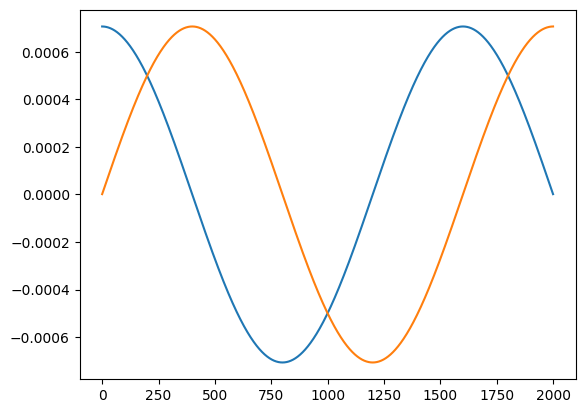

In [23]:
plt.plot(base[2])
plt.plot(base_sin[2])

### Trainings
The training is done over 30 epochs, learning rate is $10^{-3}$.
The Lipschitz constant is plot duroing training.
Here the parameter can be saved after training in file 'Trainings', and uploaded later. (1 hour)

In [53]:
exp1.train(train_set,val_set)

epoch :  0  -----  validation :  0.000215147
epoch :  1  -----  validation :  0.000212902
epoch :  2  -----  validation :  0.000210735
epoch :  3  -----  validation :  0.000208659
epoch :  4  -----  validation :  0.000206722
epoch :  5  -----  validation :  0.000204839
epoch :  6  -----  validation :  0.00020299
epoch :  7  -----  validation :  0.000201207
epoch :  8  -----  validation :  0.000199386
epoch :  9  -----  validation :  0.000197719
    ----- initial error :  0.000841523
--------------------------------------------
Training is done.
--------------------------------------------
Final Lipschitz constant =  0.17161376305606862


### Testing
We computre the averaged error over the testing set, and compute one example, on the left the signal are projected on the eigenbasis of operator $T_a^TT_a$, on the right on the finite element basis.

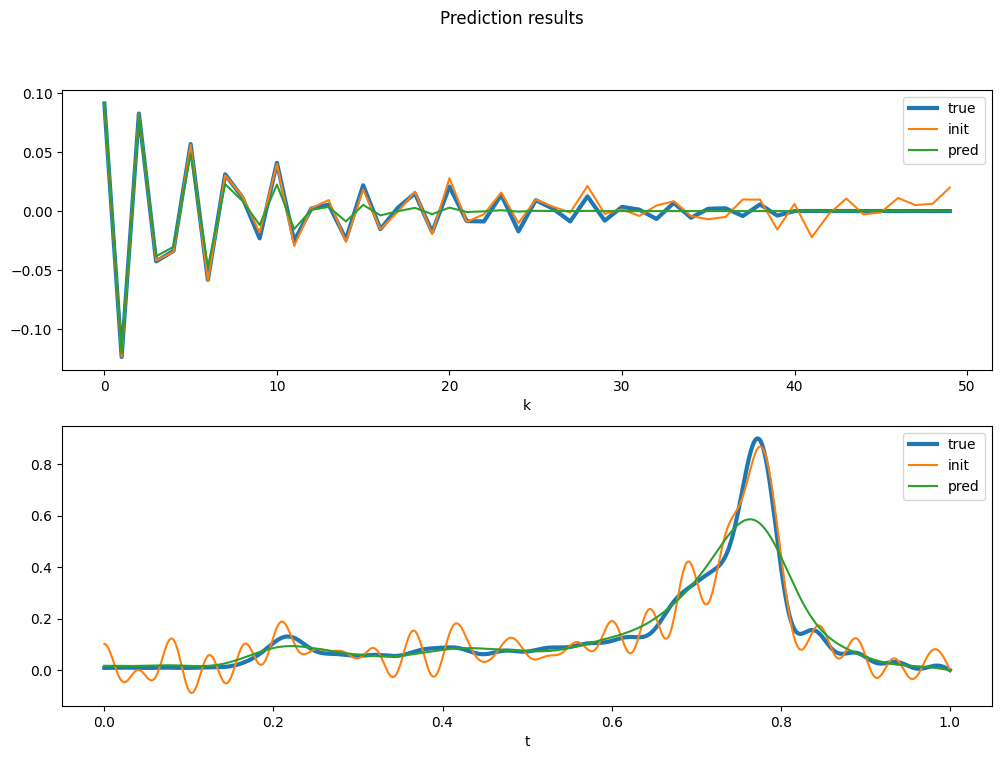

Erreur de sortie :  0.031052525521849637
Erreur initiale :  0.09502298889956236
Finite element basis error: 0.07181567557546414
Finite element basis init error: 0.04838174358936279


In [54]:
average_error = exp1.test(val_set)

### Test on a Gaussian function

<class 'str'>


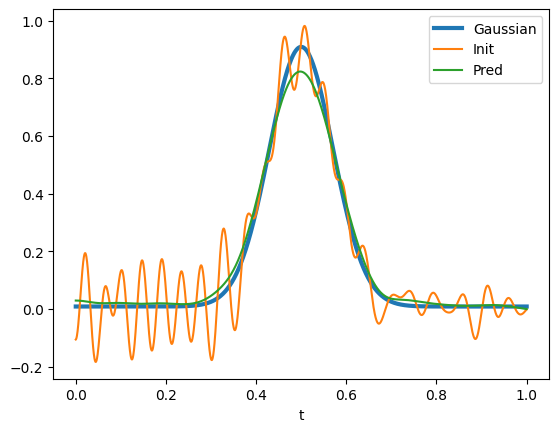

|x-xp|/|x| =  0.006841844905704739


In [55]:
exp1.test_gauss()

### Lipschitz constant

Here we implement for the Gaussian signal the lipschitz constant of the neural network, depending on the input. s or if 

$x_{in}=x_{bias}=T_a^T y^\delta$ 

In [56]:
exp1.model.Lipschitz(opt1="semi",opt2="entree11")

0.2811007349507896

$x_{in}= 0$, and $x_{bias}= T_a^T y^\delta$ 

In [57]:
exp1.model.Lipschitz(opt1="semi",opt2="entree01")

0.14827485749431407

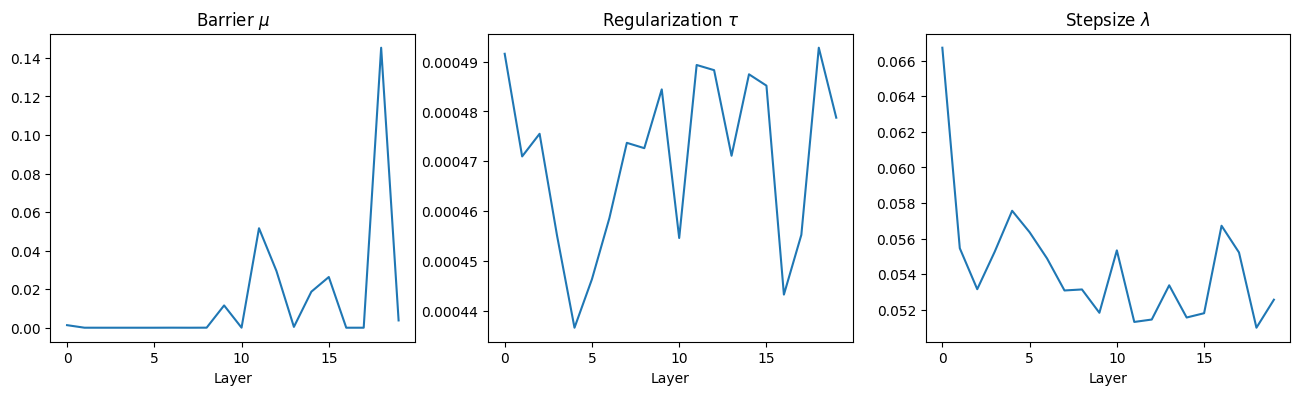

In [58]:
mu_vec = [np.squeeze(exp1.model.Layers[layer_id].mu).item() for layer_id in range(20)]
tau_vec = [np.squeeze(exp1.model.Layers[layer_id].gamma_reg[1]).item() for layer_id in range(20)]
lambda_vec = [np.squeeze(exp1.model.Layers[layer_id].gamma_reg[0]).item() for layer_id in range(20)]

im, ax = plt.subplots(1,3, figsize=(16,4))

ax[0].plot(mu_vec)
ax[0].set_xlabel('Layer')
ax[0].set_title(r'Barrier $\mu$')

ax[1].plot(tau_vec)
ax[1].set_xlabel('Layer')
ax[1].set_title(r'Regularization $\tau$')

ax[2].plot(lambda_vec)
ax[2].set_xlabel('Layer')
ax[2].set_title(r'Stepsize $\lambda$')
plt.show()


In [59]:
opt_hist = np.load('../outputs/opt_hist/model_000_opt_hist.npy', allow_pickle=True)[()]
hyper_params = opt_hist['fb_params']

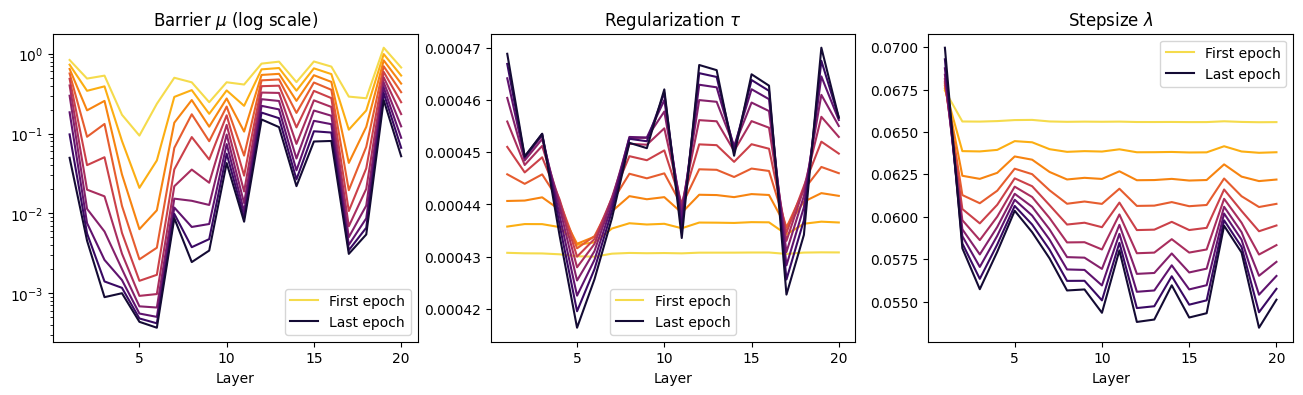

In [61]:
im, ax = plt.subplots(1,3, figsize=(16,4))
for i in range(exp1.nb_epochs):

    ax[0].plot(np.arange(1, exp1.nb_blocks+1),hyper_params[i,0], color=sns.color_palette('inferno',n_colors=exp1.nb_epochs)[exp1.nb_epochs-i-1],
        label='First epoch' if i==0 else 'Last epoch' if i==(exp1.nb_epochs-1) else '_hide')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('Layer')
    ax[0].set_title(r'Barrier $\mu$ (log scale)')

    ax[1].plot(np.arange(1, exp1.nb_blocks+1),hyper_params[i,1], color=sns.color_palette('inferno',n_colors=exp1.nb_epochs)[exp1.nb_epochs-i-1],
        label='First epoch' if i==0 else 'Last epoch' if i==(exp1.nb_epochs-1) else '_hide')
    ax[1].set_xlabel('Layer')
    ax[1].set_title(r'Regularization $\tau$')

    ax[2].plot(np.arange(1, exp1.nb_blocks+1),hyper_params[i,2], color=sns.color_palette('inferno',n_colors=exp1.nb_epochs)[exp1.nb_epochs-i-1],
        label='First epoch' if i==0 else 'Last epoch' if i==(exp1.nb_epochs-1) else '_hide')
    ax[2].set_xlabel('Layer')
    ax[2].set_title(r'Stepsize $\lambda$')

for i in range(3): ax[i].legend()
plt.show()

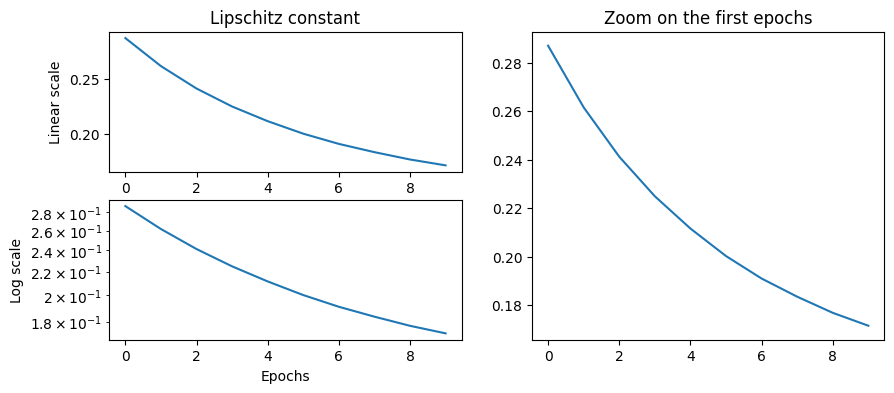

In [62]:
lip_cte = opt_hist['lipschitz']
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(2,2,1)
ax.plot(lip_cte)
ax.set_ylabel('Linear scale')
ax.set_title('Lipschitz constant')
#ax.set_xticks(np.arange(1,exp1.nb_epochs+1,3))

ax = fig.add_subplot(2,2,3)
ax.plot(lip_cte)
ax.set_xlabel('Epochs')
ax.set_ylabel('Log scale')
ax.set_yscale('log')
#ax.set_xticks(np.arange(1,exp1.nb_epochs+1,3))

ax = fig.add_subplot(2,2,(2,4))
ax.plot(lip_cte[:15])
ax.set_title('Zoom on the first epochs')
#ax.set_xticks(np.arange(1,16,3))

plt.show()

In [1]:
# im, ax = plt.subplots(exp1.nb_epochs,3, figsize=(18,80))

# for i in range(exp1.nb_epochs):
#     ax[i][0].plot(hyper_params[i,0])
#     ax[i][0].set_xlabel('Layer')
#     ax[i][0].set_title(r'Barrier $\mu$')

#     ax[i][1].plot(hyper_params[i,1])
#     ax[i][1].set_xlabel('Layer')
#     ax[i][1].set_title(r'Regularization $\tau$')

#     ax[i][2].plot(hyper_params[i,2])
#     ax[i][2].set_xlabel('Layer')
#     ax[i][2].set_title(r'Stepsize $\lambda$')
# plt.show()